In [1]:
import pandas as pd
import os
import warnings
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [2]:
warnings.filterwarnings("ignore")

In [3]:
working_dir = os.getcwd()
rel_path = r"project_resources\chembl_molekuly.csv"
molekuly_csv_abs_file_path = os.path.join(working_dir, rel_path)
# loads csv file from directory

In [4]:
# dir for useful stuff for the actual essay
rel_path = r"project_results\graphs"
project_results_graphs = os.path.join(working_dir, rel_path)

In [5]:
df = pd.read_csv(molekuly_csv_abs_file_path, sep=";")
statistika = df["Standard Type"].value_counts()
# print(statistika)

In [6]:
result = df[(df["Standard Type"] == "t1/2") | (df["Standard Type"] == "T1/2")]
t_half_rel_path = r"project_resources\t_half.csv"
t_half_abs_path = os.path.join(working_dir, t_half_rel_path)
result.to_csv(t_half_abs_path, index=False)
# creates "t_half.csv" in current dir
t_half = pd.read_csv(t_half_abs_path)
# and then loads it

In [7]:
client = new_client
list_smiles = []
list_chembl_id = t_half["Molecule ChEMBL ID"]
for chembl_id in list_chembl_id:
    molecule = client.molecule
    compound = molecule.filter(chembl_id=chembl_id)[0]
    list_smiles.append(compound['molecule_structures']["canonical_smiles"])
#print(list_smiles)

In [8]:
# takes a list of smiles strings,output is a corresponding Morgan fingerprint as a list
list_fingerprint = []
for smi in list_smiles:
    mol = Chem.MolFromSmiles(smi)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 124)
    vector = np.array(fingerprint)
    list_fingerprint.append(vector)
    #print(list_fingerprint)

In [9]:
# data sets filtering for ML
t_half = pd.read_csv(t_half_abs_path)

t_half = np.array(t_half['Standard Value'])
t_half_float = t_half.astype(float)
t_filtered = t_half_float[t_half>0]

array_fingerprint = np.array(list_fingerprint)
array_fingerprint_filtered = array_fingerprint[t_half>0]

In [10]:
# x su len fingerprint ako jeden numpy array,
# y su len t_half hodnoty ako jeden numpy array, pouzit len molekuly kde existuje aj X aj y hodnota
x = array_fingerprint_filtered
y = t_filtered

idx_train, idx_test = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)

x_train = x[idx_train]
x_test = x[idx_test]

y_train = y[idx_train]
y_test = y[idx_test]

array_fingerprint_filtered_train = array_fingerprint_filtered[idx_train]
array_fingerprint_filtered_test = array_fingerprint_filtered[idx_test]

print(t_filtered.shape, array_fingerprint_filtered.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70,) (70, 124) (56, 124) (14, 124) (56,) (14,)


In [11]:
def create_scatter_plot(x_axis, y_axis, plot_title, x_label, y_label, diag=False, error_bars=False, x_min=None, y_min=None, x_max=None, y_max=None, save_dir=None, save_file_name=None):
    # !!! perhaps shorten input of function by using a class?
    # !!! add error_bars after std has been fixed
    # x_axis, y_axis ... input values to be displayed on their respective axis
    # x_min, y_min, x_max, y_max ... decide the span of the graph
    plt.scatter(x_axis, y_axis, edgecolors=None, c='b', alpha=0.2)
    if diag:
        diag = np.linspace(x_min, x_max)
        plt.plot(diag, diag, linestyle='dotted')
    #if error_bars:
        #error_bars()
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.suptitle(plot_title)
    if save_dir and save_file_name:
        plt.savefig(os.path.join(save_dir, save_file_name))
    plt.show()

In [12]:
def mach_learn(x_train, x_test, y_train, y_test, reg, plot_title):
    # výcvik strojoveho modelu
    reg = reg.fit(x_train, y_train)
    # predict training set
    y_train_predict = reg.predict(x_train)
    # predict test set
    y_test_predict = reg.predict(x_test)
    # error train je pre info, test je dolezita
    train_error = np.mean(np.abs(y_train_predict-y_train))
    test_error = np.mean(np.abs(y_test_predict-y_test))
    print(f"MAE train: {train_error:.4f}")
    print(f"MAE test: {test_error:.4f}")

    # idealne data na diagonale
    # !!! změnit konec inputu create_scatter_plot aby byl více obecný
    create_scatter_plot(y_test, y_test_predict, f"{plot_title}", '$t_{1/2}$ (real)', '$t_{1/2}$ (predicted)', True, False, -1, -1, 3.5, 3.5)

In [13]:
def model_choice(ml_type):

    # !!! redundantní fce kvůli param_tuning -> odstranit včetně následujících grafů?
    # !!! nebo odstranit pouze fci a grafy nahradit ekvivalentními ale pomocí param_tuning?

    if ml_type == 'linear':
        reg = linear_model.ElasticNet(alpha=0.001, l1_ratio=1)
        plot_title = "Linear"

    if ml_type == 'KRR':
        reg = KernelRidge(alpha=0.1)
        plot_title = "Kernel ridge regressor"

    if ml_type == 'RF':
        reg = RandomForestRegressor(max_depth=None, random_state=0)
        plot_title = "Random forest regressor"

    if ml_type == 'GB':
        reg = GradientBoostingRegressor(random_state=1, loss='absolute_error', max_depth=5, n_estimators=1000)
        plot_title = "Gradient boosting regressor"

    if ml_type == 'ANN':
        reg = MLPRegressor(random_state=1, max_iter=5000, learning_rate_init=0.001, alpha=0, hidden_layer_sizes=[10,10])
        plot_title = "Limited-memory BFGS"
    print(f"using ML type {ml_type}")

    return reg, plot_title

using ML type linear
MAE train: 0.2470
MAE test: 0.7197


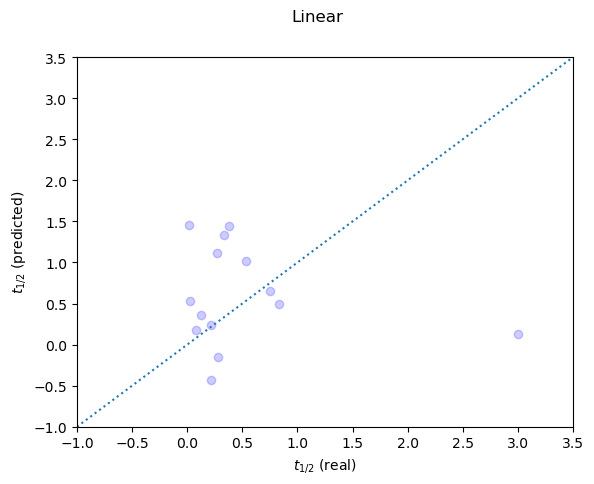

In [14]:
# opakovat pre rozne strojove metody, porovnat chyby

# !!! příp. zjednodušit volání pomocí for loop

type_ml_use = 'linear'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type KRR
MAE train: 0.2274
MAE test: 0.6352


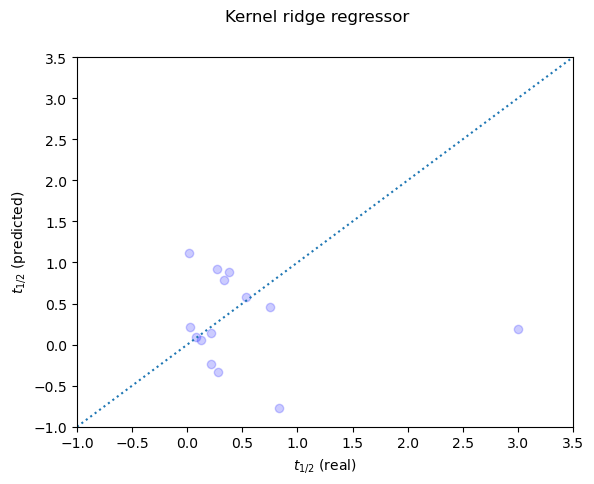

In [15]:
type_ml_use = 'KRR'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type RF
MAE train: 0.3392
MAE test: 0.5554


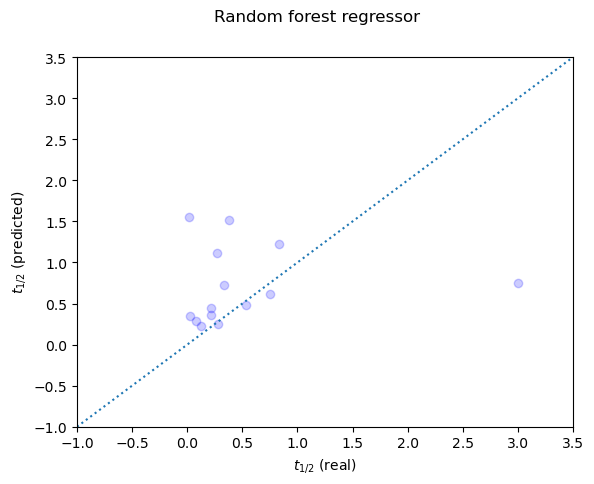

In [16]:
type_ml_use = 'RF'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type GB
MAE train: 0.2144
MAE test: 0.3618


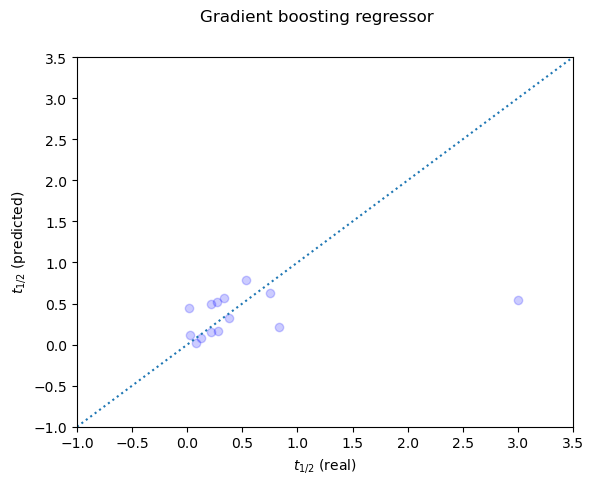

In [17]:
type_ml_use = 'GB'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

using ML type ANN
MAE train: 0.2984
MAE test: 0.4429


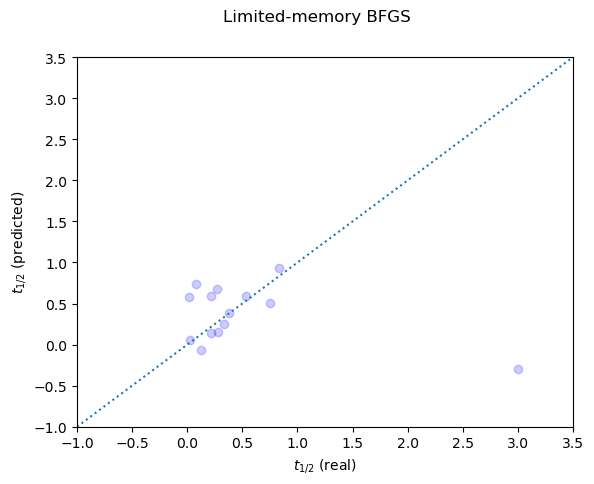

In [18]:
type_ml_use = 'ANN'
reg, plot_title = model_choice(type_ml_use)
mach_learn(x_train, x_test, y_train, y_test, reg, plot_title)

In [19]:
def param_tuning(x_train, y_train, x_test, y_test, type_ml_use, show_print=False):
    # určování hodnot pro param tuning, lze vylepšit pomocí np.random.randint

    # !!! upravit linear hyperparams aby bylo lepší než před tuning

    if type_ml_use == 'linear':
        param_grid = {
            'fit_intercept': [True],
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2],
            'l1_ratio': [0, 0.1, 0.5, 0.9, 1]
        }
        reg = linear_model.ElasticNet()

    if type_ml_use == 'KRR':
        param_grid = {
            "alpha": np.logspace(-4, 1, 20),
            "gamma": np.logspace(-14, 0, 20),
            "kernel": ['linear', 'laplacian', 'rbf']
        }
        reg = KernelRidge()

    if type_ml_use == 'GB':
        param_grid = {
            'n_estimators': [20, 200, 2000],
            'learning_rate': [0.02, 0.05],
            'max_depth': [1, 2, 3, 5],
            'min_samples_leaf': [5, 10, 20],
            'min_samples_split': [2, 5]
        }
        reg = GradientBoostingRegressor()

    if type_ml_use == 'RF':
        param_grid = {
            'max_depth': [None, 2, 3, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2'],
            'n_estimators': [10, 20, 50, 100, 200],
        }
        reg = RandomForestRegressor()

    if type_ml_use == 'ANN':
        param_grid = {
            'learning_rate_init': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05],
            'hidden_layer_sizes': [[5], [10], [20], [50], [5]*2, [10]*2, [20]*2, [50]*2, [5]*3, [10]*3]
        }
        reg = MLPRegressor()

    grid = GridSearchCV(reg, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=1), verbose=0)
    grid.fit(x_train, y_train)
    best_reg = grid.best_estimator_
    y_train_predict = best_reg.predict(x_train)
    y_test_predict = best_reg.predict(x_test)
    abs_error = np.abs(y_test_predict-y_test)
    if show_print:
        print(type_ml_use)
    # retrain on best hyperparameters
    best_reg.fit(x_train, y_train)

    return y_train_predict, y_test_predict, abs_error

In [20]:
def to_rdkit_fingerprint(fps):
    rdkit_fingerprints = []
    for prnt in fps:
        bitstring = "".join(prnt.astype(str))
        fp = DataStructs.cDataStructs.CreateFromBitString(bitstring)
        rdkit_fingerprints.append(fp)
    return rdkit_fingerprints

In [21]:
fps = to_rdkit_fingerprint(array_fingerprint_filtered_test)
fp2s = to_rdkit_fingerprint(array_fingerprint_filtered_train)
tanimoto_similarities = []
for x in fps:
    fpsx = []
    for y in fp2s:
        fpsx.append(DataStructs.TanimotoSimilarity(x,y))
    max_tanimoto = max(fpsx)
    tanimoto_similarities.append(max_tanimoto)
print(tanimoto_similarities, f"length: {len(tanimoto_similarities)}")

[0.810126582278481, 0.40625, 0.5692307692307692, 0.9137931034482759, 0.5679012345679012, 0.8833333333333333, 0.8571428571428571, 0.9154929577464789, 0.9193548387096774, 1.0, 0.6052631578947368, 0.3888888888888889, 0.8529411764705882, 0.3684210526315789] length: 14


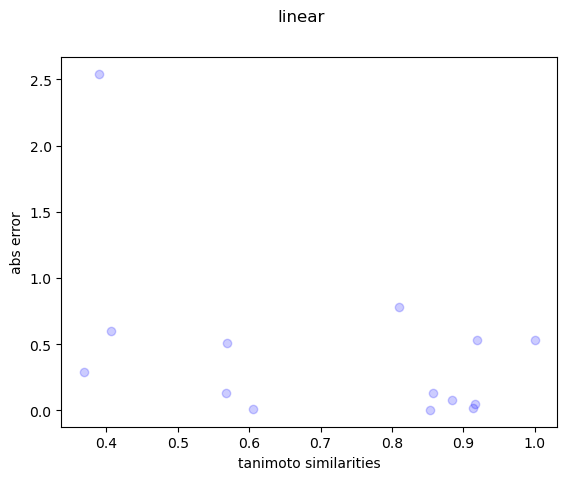

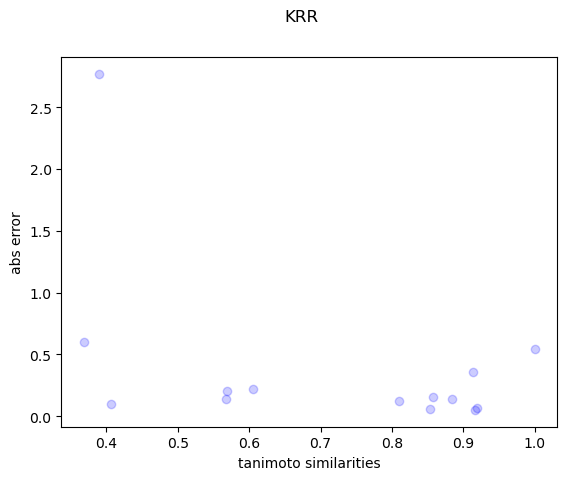

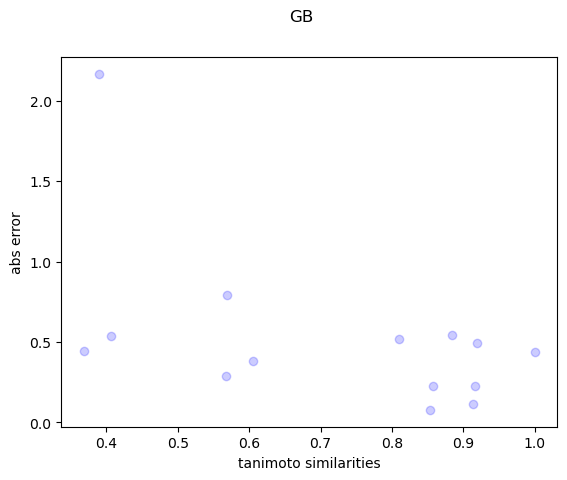

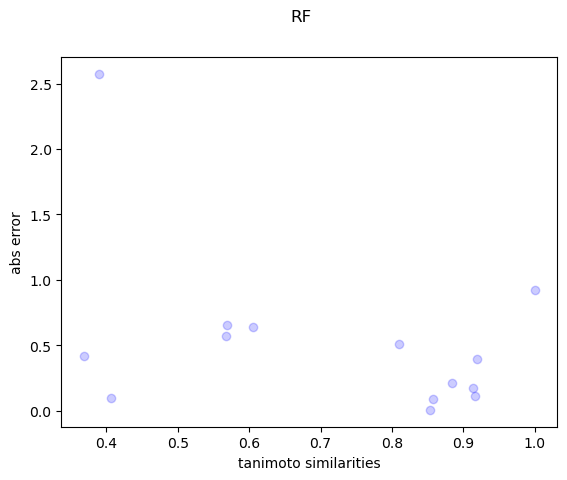

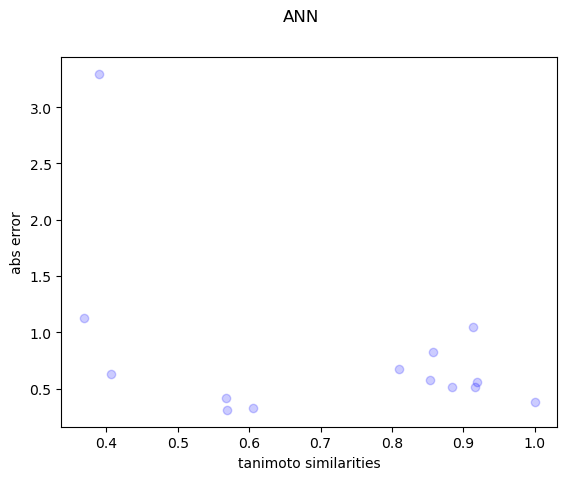

In [22]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
for model in models:
    y_train_predict, y_test_predict, abs_error = param_tuning(x_train, y_train, x_test, y_test, model)
    plot = plt.scatter(tanimoto_similarities, abs_error, edgecolors=None, c='b', alpha=0.2)
    plt.xlabel('tanimoto similarities')
    plt.ylabel('abs error')
    plt.suptitle(f"{model}")
    #plt.savefig(os.path.join(project_results_graphs, plot_title))
    plt.show()

In [25]:
def mean_error(x_train, y_train, x_test, y_test, type_ml_use, show_print=False):
    # !!! asdf...dummy proměnná, protože param_tuning má 3 outputy, i když nejsou všechny užitečné
    y_train_predict, y_test_predict, asdf = param_tuning(x_train, y_train, x_test, y_test, type_ml_use)
    train_error = np.mean(np.abs(y_train_predict-y_train))
    abs_error = np.abs(y_test_predict-y_test)
    test_error = np.mean(abs_error)
    if show_print:
        print(f"MAE train: {train_error:.4f}")
        print(f"MAE test: {test_error:.4f}")

    return y_test_predict

In [26]:
models = ["linear", "KRR"]
y_predict_dict = {
    "linear",
    "KRR",
    "GB",
    "RF",
    "ANN"
}
std_dict = {
    "linear",
    "KRR",
    "GB",
    "RF",
    "ANN"
}
for model in models:
    y_test_out_final = []
    for i in range(5):
        y_test_out = mean_error(x_train, y_train, x_test, y_test, model)
        y_test_out_final.append(y_test_out)
    y_test_out_final_concat = np.vstack(y_test_out_final)
    mol_avg_error = np.average(y_test_out_final, axis=0)
    standard_deviation = np.std(y_test_out_final_concat, axis=0)
    print(f"{model}\naverage molecule error: {mol_avg_error}\n standard deviation: {standard_deviation}")

linear
average molecule error: [ 1.15642558  0.93628272  0.5201211   0.73342816 -0.00555751  0.29493439
  0.40495357  0.16716385  0.79634824  0.61780304  0.04191675  0.45888068
  0.28637488  0.53959438]
 standard deviation: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
KRR
average molecule error: [0.25580006 0.23460921 0.21518952 0.39260619 0.26123533 0.35568714
 0.37610162 0.26725264 0.33026767 0.63059832 0.25108971 0.23141212
 0.22906093 0.23299686]
 standard deviation: [0.00000000e+00 0.00000000e+00 2.77555756e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.77555756e-17
 0.00000000e+00 0.00000000e+00]
